# Zillow Time Series Analysis

## Business Understanding

#isolated according to descriptive statistics the top 10 zips for each group 

## Data Understanding

## EDA & Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',300)
pd.set_option('display.max_info_columns',300)
pd.set_option('display.max_rows', 300)

df = pd.read_csv('https://raw.githubusercontent.com/learn-co-curriculum/dsc-phase-4-project/main/time-series/zillow_data.csv')
df.to_csv('zillow_data.csv', index=False)

In [2]:
# Import the check_stationarity function from previous lab
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [4]:
print(df.shape)
print('Unique Region IDs are {}'.format(df['RegionID'].nunique()))
print('Unique Region Names are {}'.format(df['RegionName'].nunique()))
print('Unique Cities are {}'.format(df['City'].nunique()))
print('Unique Metro Areas are {}.'.format(df['Metro'].nunique()))
print('Unique States are {}'.format(df['State'].nunique()))

(14723, 272)
Unique Region IDs are 14723
Unique Region Names are 14723
Unique Cities are 7554
Unique Metro Areas are 701.
Unique States are 51


There seem to be no duplicate entries, though understandably there are fewer unique cities than zip codes ("region names"), as larger cities especially encompass multiple zip codes.

We can also tell from the column names that the dataset includes the median prices of homes from April 1996 to April 2018. 

In [5]:
df['Metro'].value_counts()

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
                                 ... 
Salina                              1
Sedalia                             1
Starkville                          1
North Platte                        1
Pampa                               1
Name: Metro, Length: 701, dtype: int64

In [6]:
df['City'].value_counts()

New York       114
Los Angeles     95
Houston         88
San Antonio     48
Washington      45
              ... 
Mantachie        1
Mazeppa          1
Dacula           1
Hummelstown      1
Wilmette         1
Name: City, Length: 7554, dtype: int64

The top-represented metro areas are New York, Los Angeles metro area, and Chicago. The top-represented cities are New York, Los Angeles, and Houston. 

The only identifier column with a null value is "Metro." The other null values are found in the date columns. 

In [7]:
# Replace nulls in dataframe with row average 
m = df.mean(axis=1)
for i,col in enumerate(df): 
    df.iloc[:,i] = df.iloc[:,i].fillna(m)

Next, I need to determine the geographic regions and/or cities I'm going to focus on for my analysis. To do this, I'm going to use a rough estimate of return on investment (ROI), which, just for this purpose, will simply be value of the property on the most recent "time of holding" in the data (April 2018), measured against the "cost" of the property on an artifically selected purchase date. 

I went with June 2009 as my "purchase date," as this was declared the end of the recession by the [National Bureau of Economic Research](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008). The 2008 financial crisis and subsequent recession had a devastating effect on the real estate market, and I didn't want this extraordinary event to have an outsize effect on the areas I chose for my analysis. 

In [8]:
#Create a new column that shows the return on investment on a property 
#held in April 2018 if purchased in April 2015. 
df['roi'] = (((df['2018-04']-df['2009-06'])/df['2009-06'])*100).round(2)

In [9]:
top_rois = df.sort_values(by=['roi'],ascending=False)

In [10]:
#Creating new dataframe with just the ROIs that show a positive return on investment
rois_over_100 = df[df['roi']>100]

In [11]:
rois_over_100['State'].value_counts()

CA    160
CO     26
FL     19
MA     12
NY      8
WA      7
TN      5
PA      4
ND      2
MI      2
SC      1
GA      1
TX      1
OK      1
NJ      1
AL      1
DC      1
AZ      1
Name: State, dtype: int64

In [12]:
pops = pd.read_csv("population_by_zip_2010.csv") 
pops.shape

(1622831, 6)

In [13]:
pops['zipcode'].nunique()

33119

In [14]:
pops = pops.drop(['minimum_age','maximum_age','gender','geo_id'], axis=1)

In [15]:
pops.head()

,population,zipcode
0,50,61747
1,5,64120
2,1389,95117
3,231,74074
4,56,58042


In [16]:
pops.shape

(1622831, 2)

In [17]:
#Have to aggregate 
zip_groups = pops.groupby([ "zipcode"]).sum().reset_index()
zip_groups.shape

(33119, 2)

In [18]:
# Merge zipcodes/population df with real estate df 
merge = zip_groups.merge(df, how='inner', left_on = 'zipcode', right_on='RegionName')
merge.shape

(14707, 275)

In [19]:
merge.head()

,zipcode,population,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi
0,1001,50307,58196,1001,Agawam,MA,Springfield,Hampden,5851,113100.0,112800.0,112600.0,112300.0,112100.0,111900.0,111800.0,111700.0,111700.0,111900.0,112100.0,112300.0,112500.0,112800.0,113000.0,113300.0,113600.0,113900.0,114200.0,114500.0,114800.0,115200.0,115600.0,115900.0,116200.0,116400.0,116600.0,116700.0,116800.0,116900.0,117100.0,117300.0,117500.0,117800.0,118300.0,118700.0,119100.0,119500.0,120000.0,120400.0,120900.0,121300.0,121700.0,122100.0,122600.0,123100.0,123800.0,124400.0,124900.0,125400.0,125900.0,126400.0,127000.0,127500.0,128100.0,128800.0,129400.0,130200.0,131100.0,131900.0,132700.0,133400.0,134100.0,134800.0,135400.0,136100.0,136800.0,137500.0,138400.0,139400.0,140600.0,141800.0,143000.0,144200.0,145400.0,146800.0,148200.0,149500.0,150900.0,152600.0,154500.0,155900.0,156800.0,157700.0,158700.0,159900.0,161100.0,162200.0,163300.0,164300.0,165500.0,166800.0,168100.0,169300.0,170600.0,172000.0,173600.0,175300.0,177200.0,179200.0,181300.0,183500.0,185700.0,187600.0,189500.0,191600.0,193900.0,196400.0,199300.0,202300.0,205500.0,208600.0,211500.0,214200.0,216800.0,219000.0,220500.0,221600.0,222200.0,222500.0,222600.0,222400.0,222100.0,221600.0,221100.0,220700.0,220600.0,220600.0,220700.0,221100.0,221600.0,222000.0,222200.0,221900.0,221300.0,220300.0,219200.0,218100.0,217100.0,216200.0,215200.0,213900.0,212400.0,210800.0,209100.0,207800.0,206800.0,205900.0,205100.0,204300.0,203700.0,203200.0,202500.0,201700.0,201000.0,200300.0,199500.0,198800.0,197900.0,197200.0,197100.0,197500.0,198100.0,198600.0,198300.0,197900.0,197800.0,198300.0,199100.0,199700.0,199500.0,198900.0,197500.0,195900.0,193500.0,190900.0,189600.0,190100.0,190200.0,189700.0,188900.0,188100.0,187600.0,187900.0,188500.0,188300.0,187500.0,187500.0,187800.0,187200.0,186200.0,185800.0,185300.0,184

In [20]:
#Drop unnecessary identifier columns 
joined = merge.drop(['RegionID','RegionName'], axis=1)
joined.head()

,zipcode,population,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi
0,1001,50307,Agawam,MA,Springfield,Hampden,5851,113100.0,112800.0,112600.0,112300.0,112100.0,111900.0,111800.0,111700.0,111700.0,111900.0,112100.0,112300.0,112500.0,112800.0,113000.0,113300.0,113600.0,113900.0,114200.0,114500.0,114800.0,115200.0,115600.0,115900.0,116200.0,116400.0,116600.0,116700.0,116800.0,116900.0,117100.0,117300.0,117500.0,117800.0,118300.0,118700.0,119100.0,119500.0,120000.0,120400.0,120900.0,121300.0,121700.0,122100.0,122600.0,123100.0,123800.0,124400.0,124900.0,125400.0,125900.0,126400.0,127000.0,127500.0,128100.0,128800.0,129400.0,130200.0,131100.0,131900.0,132700.0,133400.0,134100.0,134800.0,135400.0,136100.0,136800.0,137500.0,138400.0,139400.0,140600.0,141800.0,143000.0,144200.0,145400.0,146800.0,148200.0,149500.0,150900.0,152600.0,154500.0,155900.0,156800.0,157700.0,158700.0,159900.0,161100.0,162200.0,163300.0,164300.0,165500.0,166800.0,168100.0,169300.0,170600.0,172000.0,173600.0,175300.0,177200.0,179200.0,181300.0,183500.0,185700.0,187600.0,189500.0,191600.0,193900.0,196400.0,199300.0,202300.0,205500.0,208600.0,211500.0,214200.0,216800.0,219000.0,220500.0,221600.0,222200.0,222500.0,222600.0,222400.0,222100.0,221600.0,221100.0,220700.0,220600.0,220600.0,220700.0,221100.0,221600.0,222000.0,222200.0,221900.0,221300.0,220300.0,219200.0,218100.0,217100.0,216200.0,215200.0,213900.0,212400.0,210800.0,209100.0,207800.0,206800.0,205900.0,205100.0,204300.0,203700.0,203200.0,202500.0,201700.0,201000.0,200300.0,199500.0,198800.0,197900.0,197200.0,197100.0,197500.0,198100.0,198600.0,198300.0,197900.0,197800.0,198300.0,199100.0,199700.0,199500.0,198900.0,197500.0,195900.0,193500.0,190900.0,189600.0,190100.0,190200.0,189700.0,188900.0,188100.0,187600.0,187900.0,188500.0,188300.0,187500.0,187500.0,187800.0,187200.0,186200.0,185800.0,185300.0,184000.0,182400.0,181200.0,180400.

I went back-and-forth quite a bit on what how to distinguish "urban" vs "rural" in my dataset. At first I was going to use the Urban-Rural Commuting Areas [source here](https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes.aspx#.U9lO7GPDWHo) put out by the U.S. Department of Agriculture, but as these rely heavily on commuting, differences in population are not as stark. Yet, I wanted something with a little more granularity than the U.S Census Bureau's designation of [urbanized areas](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural/2010-urban-rural.html) (>50,000 people) and [urban clusters](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural/2010-urban-rural.html)(between 2,500 and 49,999 people). I want to make sure my model is able to distinguish a city like Los Angeles from a city like Charlotte, for example. 

I took some inspiration from how the [National Center on Education Statistics](https://nces.ed.gov/programs/edge/docs/locale_classifications.pdf) classifies large-, medium-, and small-size cities. Though these classifications rely heavily on location data (particularly to distinguish urban vs. suburban), which I'm not going to mess with, it gave me the idea to designate zip codes in terms of density. 
- very dense (100,000+). In this case, the most populous zip code in my datset is 60629, in Chicago, with a population of 341,748.  
- dense (25,000 - 99,999). Allows us to isolate some zipcodes in some nicely mid-size cities like Naples, FL; Jacksonville, FL;  and Portland, OR. 
- not dense (fewer than 25,000). 

This method is imperfect, as it does not take location into account, and zip codes are not a uniform size. However, I think this will allow me to accomplish my primary purpose of isolating real estate trends for big-name cities vs. smaller cities and towns. 

In [21]:
vdense = joined.loc[joined['population']>=100000]
vdense.sort_values(by='population',ascending=True).head()

,zipcode,population,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi
1582,11231,100008,New York,NY,New York,New York,1996,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,1.719159e+06,969500.0,940900.0,912300.0,887300.0,869900.0,862700.0,867700.0,884600.0,911100.0,943300.0,979600.0,1016900.0,1050700.0,1080900.0,1109000.0,1132100.0,1148200.0,1160200.0,1170900.0,1182700.0,1196200.0,1209600.0,1223500.0,1236900.0,1247200.0,1255800.0,1266000.0,1277100.0,1287600.0,1297700.0,1307900.0,1319800.0,1333100.0,1345100.0,1357000.0,1371600.0,1387600.0,1406900.0,1430100.0,1451100.0,1463900.0,1468500.0,1466900.0,1463800.0,1460800.0,1455000.0,1449300.0,1449000.0,1453200.0,1462600.0,1473500.0,1476700.0,1468700.0,1452800.0,1432700.0,1415800.0,1403400.

In [22]:
dense = joined.loc[(joined['population']>= 25000) & (joined['population']<= 99999)]
dense.sort_values(by=['population'],ascending =False)

,zipcode,population,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi
4569,29209,99972,Columbia,SC,Columbia,Richland,2016,70300.000000,70300.000000,70300.000000,70400.000000,70500.000000,70700.000000,71000.000000,71400.000000,72000.000000,72700.000000,73500.000000,74300.000000,75300.000000,76300.000000,77400.000000,78600.000000,79800.000000,81000.000000,82300.000000,83600.000000,85000.000000,86400.000000,87700.000000,89000.000000,90300.000000,91500.000000,92500.000000,93400.000000,94000.000000,94400.000000,94500.000000,94400.000000,94200.000000,93800.000000,93500.000000,93100.000000,92600.000000,92300.000000,91900.000000,91800.000000,91700.000000,91800.000000,92000.000000,92300.000000,92800.000000,93400.000000,94200.000000,95100.000000,96100.000000,97100.000000,98000.000000,99000.000000,99800.000000,100600.000000,101100.000000,101500.000000,101700.000000,101700.000000,101600.000000,101500.000000,101200.000000,100900.000000,100600.000000,100500.000000,100500.000000,100600.000000,100800.000000,101200.000000,101800.000000,102400.000000,103000.000000,103600.000000,104200.000000,104700.000000,105200.000000,105700.000000,106000.000000,106300.000000,106500.000000,106600.000000,106700.000000,106700.000000,106900.000000,107200.000000,107600.000000,107800.000000,108100.000000,108400.000000,108700.000000,109100.000000,109700.000000,110200.000000,110600.000000,110800.000000,110900.000000,110900.000000,111100.000000,111300.000000,111500.000000,111700.000000,111800.000000,112000.000000,112300.000000,112800.000000,113600.000000,114600.000000,115600.000000,116600.000000,117700.000000,118700.000000,119800.000000,120900.000000,121900.000000,122800.000000,123500.000000,124100.000000,124700.000000,125200.0,125600.0,126000.0,126400.0,126700.0,127000.0,127300.0,127600.0,127800.0,128000.0,128200.0,128300.0,128400.0,128600.0,128900.0,129300.0,129500.0,129700.0,129900.0,130000.0,13

In [23]:
not_dense = joined.loc[(joined['population']<= 24999)]
not_dense.sort_values(by=['population'],ascending=False)

,zipcode,population,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,roi
4554,29127,24999,Prosperity,SC,Newberry,Newberry,8108,72000.000000,72200.000000,72300.000000,72500.000000,72700.000000,72800.000000,72900.000000,73000.000000,73200.000000,73500.000000,73800.000000,74000.000000,74300.000000,74600.000000,74900.000000,75300.000000,75800.000000,76300.000000,76900.000000,77700.000000,78600.000000,79700.000000,80800.000000,82000.000000,83400.000000,84800.000000,86400.000000,88000.000000,89600.000000,91100.000000,92600.000000,94100.000000,95700.000000,97200.000000,98700.000000,100000.000000,101300.000000,102500.000000,103800.000000,105000.000000,106000.000000,107000.000000,107900.000000,108800.000000,109800.000000,110900.000000,111900.000000,112800.000000,113600.000000,114400.000000,115100.000000,115800.000000,116300.000000,116700.000000,117000.000000,117400.000000,117900.000000,118400.000000,119000.000000,119500.000000,120000.000000,120500.000000,120900.000000,121200.000000,121300.000000,121200.000000,120900.000000,120600.000000,120300.000000,120100.000000,120000.000000,119800.000000,119500.000000,119300.000000,119200.000000,119100.000000,118900.000000,118600.000000,118100.000000,117800.000000,117800.000000,118200.000000,118800.000000,119500.000000,120400.000000,121200.000000,122100.000000,123100.000000,124200.000000,125200.000000,126100.000000,127100.000000,128300.000000,129800.000000,131400.000000,133000.000000,134500.000000,136300.000000,138300.000000,140500.000000,142900.000000,145100.000000,147100.000000,148700.000000,149800.000000,150600.000000,151000.000000,151200.000000,151400.000000,151300.000000,150600.000000,149700.000000,149400.000000,150700.000000,153500.000000,156500.000000,158600.000000,159900.000000,160700.000000,161400.000000,162300.000000,163100.000000,163800.000000,164200.000000,164400.000000,1.642000e+05,1.638000e+05,1.632000e+05,1.626000e+0

In [24]:
not_dense.shape

(5824, 273)

In [25]:
#Reshape all 3 dataframes from wide to long format 
#Function to melt dataframe with the datetime columns
#Set date column as index for dataset
def melt(df):
    melted = pd.melt(
        df, 
        id_vars = ['zipcode','population','City','State','Metro','CountyName','SizeRank','roi'], 
        var_name = ['time']) 
    return melted

In [26]:
vdense = melt(vdense)

In [27]:
vdense['time'] = pd.to_datetime(vdense['time'])

In [28]:
vdense = vdense.set_index('time')

In [29]:
dense = melt(dense)

In [30]:
dense['time'] = pd.to_datetime(dense['time'])

In [31]:
dense = dense.set_index('time')

In [32]:
not_dense = melt(not_dense)

In [33]:
not_dense['time'] = pd.to_datetime(not_dense['time'])

In [34]:
not_dense = not_dense.set_index('time')

In [35]:
#Function to change certain columns from int64 to string
def to_string(df): 
    df['zipcode'] = df['zipcode'].astype(str)
    df['SizeRank'] = df['SizeRank'].astype(str)
    df['population'] = df['population'].astype(str)
    df['roi'] = df['roi'].astype(str)
    return df

In [36]:
vdense = to_string(vdense)
dense = to_string(dense)
not_dense = to_string(not_dense)

In [37]:
#Now to figure out which zipcodes to focus on 
not_dense_roi = not_dense.drop_duplicates(subset=['zipcode']).roi

In [38]:
#plt.hist(not_dense_roi.to_numpy())

In [39]:
dense_roi = dense.drop_duplicates(subset=['zipcode']).roi

In [40]:
#plt.hist(dense_roi.to_numpy())

In [41]:
vdense_roi = vdense.drop_duplicates(subset=['zipcode']).roi

In [42]:
#plt.hist(vdense_roi.to_numpy())

In [43]:
not_dense_zips = not_dense.drop_duplicates(subset='zipcode').sort_values(by=['roi'],ascending=False).iloc[:10].zipcode.to_list()

In [44]:
dense_zips = dense.drop_duplicates(subset='zipcode').sort_values(by=['roi'],ascending=False).iloc[:10].zipcode.to_list()

In [45]:
vdense_zips = vdense.drop_duplicates(subset='zipcode').sort_values(by=['roi'],ascending=False).iloc[:10].zipcode.to_list()

In [46]:
print(not_dense_zips)
print(dense_zips)
print(vdense_zips)

['2111', '80543', '74740', '80651', '4411', '94028', '11975', '94038', '27980', '80102']
['48034', '98008', '92586', '94618', '33140', '90008', '92583', '33181', '94402', '48220']
['92571', '94066', '91950', '11106', '94014', '33162', '95380', '98105', '33055', '33135']


In [47]:
nd_top10 = not_dense[not_dense['zipcode'].isin(not_dense_zips)]

In [48]:
dense_top10 = dense[dense['zipcode'].isin(dense_zips)]

In [49]:
vd_top10 = vdense[vdense['zipcode'].isin(vdense_zips)]

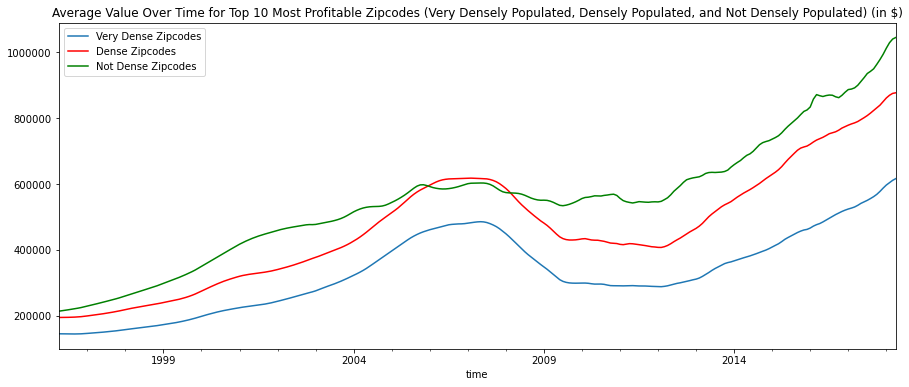

In [50]:
fig1 = plt.figure(figsize=(15,6))
ax1 = fig1.add_subplot()

vd_top10.groupby(pd.Grouper(freq='M')).mean()['value'].plot(label = 'Very Dense Zipcodes')
dense_top10.groupby(pd.Grouper(freq='M')).mean()['value'].plot(c='r',label='Dense Zipcodes')
nd_top10.groupby(pd.Grouper(freq='M')).mean()['value'].plot(c='g', label='Not Dense Zipcodes')

ax1.ticklabel_format(axis='y', style='plain')

plt.title(label='Average Value Over Time for Top 10 Most Profitable Zipcodes (Very Densely Populated, Densely Populated, and Not Densely Populated) (in $)')

plt.legend();
#ax1.plot(vd_top10.index, vd_top10['value'])
#ax1.plot(dense_top10['value'])

The above graph represents the average value over time for each of the three categories of zipcodes. This visualization offers some insights (surprisingly, the value of the three categories over time is the inverse of what I expected, with "not dense"/rural zipcodes being the most expensive, and "very dense" zipcodes being the least expensive. 


However, this graph, being cumulative does not communicate specific information about our target, ROI. To figure gain more information about ROI, we'll convert the dataframes one last time to make the "ROI" column an integer, and convert the "Value" column to string (since we're done with that for now).

Furthermore, I can see here that the data is not stationary and follows a general upward trend. We can use `differencing` as one strategy to try and get rid of some of that trend. Next, I'll calculate how the value of homes in each zipcode have changed month-to-month. From there, I will use the value "difference" to create a new "ROI" column, and then be able to plot the moving and rolling averages for each zip code. 

In [51]:
# Doing some datatype conversions for top 10 dataframes
# Since ROI was converted to a string for the visualization above, I want to convert back to integer
vd_top10['roi'] = pd.to_numeric(vd_top10['roi'])
dense_top10['roi'] = pd.to_numeric(dense_top10['roi'])
nd_top10['roi'] = pd.to_numeric(nd_top10['roi'])

In [52]:
# As of right now the "ROI" column displays the AVERAGE
# ROI for that zip code from the time period 2009-2018. I now want ROI to reflect month-to-month
# changes in ROI for that particular zipcode. I need to calculate the ROI from month to month. 

# Will rename current 'roi' column as 'average roi' before I calculate above
vd_top10 = vd_top10.rename(columns={'roi':'avg_roi'})
dense_top10 = dense_top10.rename(columns={'roi':'avg_roi'})
nd_top10 = nd_top10.rename(columns={'roi':'avg_roi'})

### Checking Variance

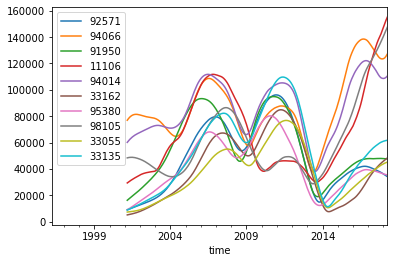

In [53]:
# Using the very dense zip codes as an example
for x in vdense_zips:
    frame = vdense[vdense.zipcode==x]
    frame.assign(vol=frame.value.rolling(window=60).std()).vol.plot(label=x) 
plt.legend()

#vdense[vdense.zipcode==x]

#Select different window sizes and see when zips start to pool 
#Experiment with clustering? Hierarchical/Gaussian clustering in sklearn to find zips that are clustered according
#To their variance 

#If you have clusters of variance you can theoretically develop a model for each time series

I can see from the variance graph that there are two main clusters of zip codes with similar standard deviations. Home values of 11106, 94066, 98105, and 98105 are farther from the mean, while the remaining zip codes contain values that are closer to the mean.  

## Improving Stationarity

### Differencing Values for Each Zipcode 
I now need to drill down to focusing on individual zipcodes, as opposed to categories of zipcodes, so that I can communicate actionable, valuable information to our investor. 

I want to know how the month-to-month ROI in order to draw conclusions about the zipcodes that would be most beneficial to act on. I'm also hoping that this will help get rid of some upward trend that I saw in my data. 

In [54]:
# For each of the 3 categories of zipcodes (very dense, dense, not dense)
# group by zipcode and isolate the 'Value' column. Calculate the difference
# in price from month to month. 
vd_top10['difference'] = vd_top10.groupby(['zipcode'])['value'].diff()
vd_top10 = vd_top10.dropna()

In [55]:
dense_top10['difference'] = dense_top10.groupby(['zipcode'])['value'].diff()
dense_top10 = dense_top10.dropna()

In [56]:
nd_top10['difference'] = nd_top10.groupby(['zipcode'])['value'].diff().round(3)
nd_top10 = nd_top10.dropna()

In [57]:
#Now create new "ROI" column that uses the difference column to calculate return on investment
vd_top10['roi'] = (vd_top10['difference']/vd_top10['value'])*10000
vd_top10['roi'] = vd_top10['roi'].round(2)

In [58]:
dense_top10['roi'] = (dense_top10['difference']/dense_top10['value'])*10000
dense_top10['roi'] = dense_top10['roi'].round(2)

In [59]:
nd_top10['roi'] = (nd_top10['difference']/nd_top10['value'])*10000
nd_top10['roi'] = nd_top10['roi'].round(2)

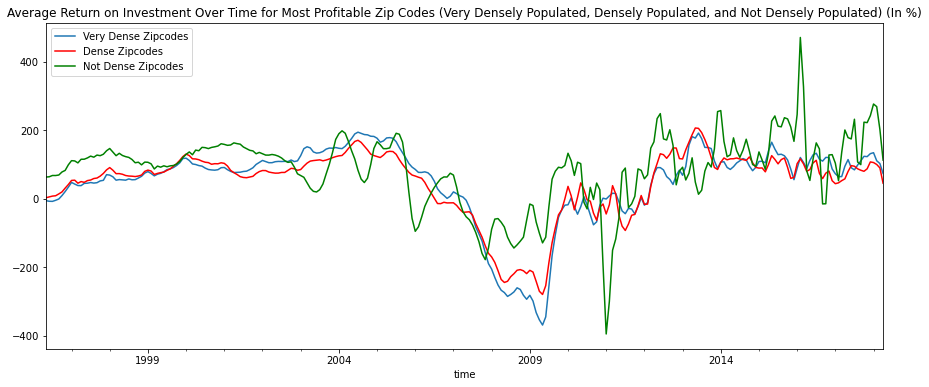

In [60]:
fig1 = plt.figure(figsize=(15,6))
ax1 = fig1.add_subplot()

vd_top10.groupby(pd.Grouper(freq='M')).mean()['roi'].plot(label = 'Very Dense Zipcodes')
dense_top10.groupby(pd.Grouper(freq='M')).mean()['roi'].plot(c='r',label='Dense Zipcodes')
nd_top10.groupby(pd.Grouper(freq='M')).mean()['roi'].plot(c='g', label='Not Dense Zipcodes')

ax1.ticklabel_format(axis='y', style='plain')

plt.title(label='Average Return on Investment Over Time for Most Profitable Zip Codes (Very Densely Populated, Densely Populated, and Not Densely Populated) (In %)')
plt.legend();

Interestingly, the ROIs over time for all three categories of zipcodes seem to be pretty close together. ROIs for very densely populated and densely populated zipcodes seem to move together, including when investments for both groups took a hit of similar magnitude in 2008-2009. However, returns for the not dense zipcodes did not decline as much (though they took a pretty sharp dip for some reason in 2011 before zooming back up). Could not-dense areas represent a safer real estate investment? 

The `differencing` technique also helped remove some of the upward trend in my dataset. The data is now moving along a general horizantal line, though there is some evidence of seasonality, as the returns for not-dense zipcodes especially seem to be peaking at regular intervals. I can get more specific at assesisng the stationarity through plotting the moving average for each zipcode:

In [61]:
#Create a function to plot moving averages for each zipcode in the 
#3 categories 
def plot_moving_average(df):
    axes = df.reset_index().pivot(index='time',
    columns = 'zipcode',
    values = 'roi').plot(
        subplots=True,
        figsize=(10,40)); 
    zips = df.zipcode.unique()
    for idx in range(len(zips)): 
        axes[idx].legend(fontsize=15, loc='upper left')

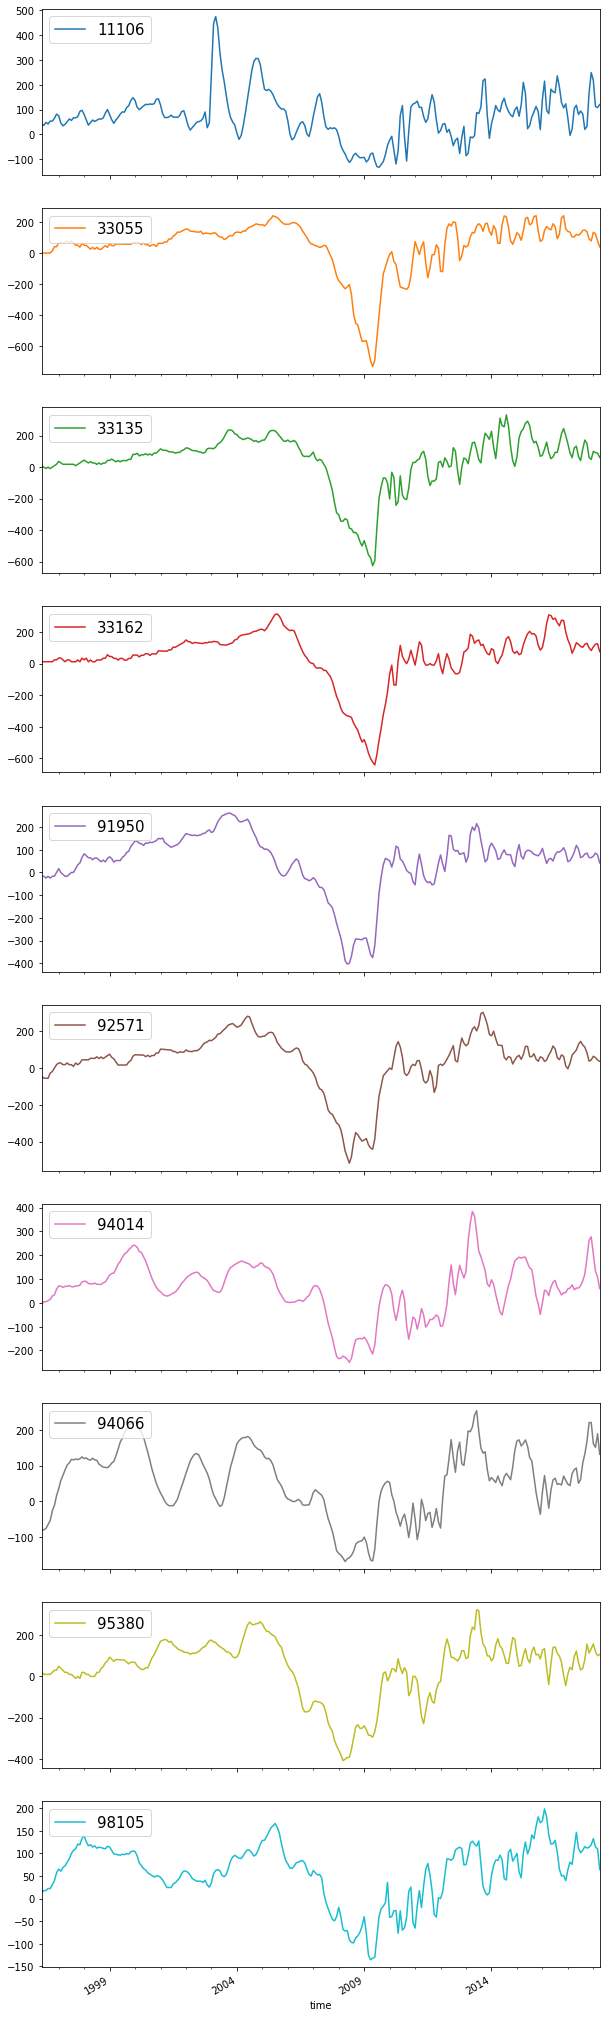

In [62]:
plot_moving_average(vd_top10)

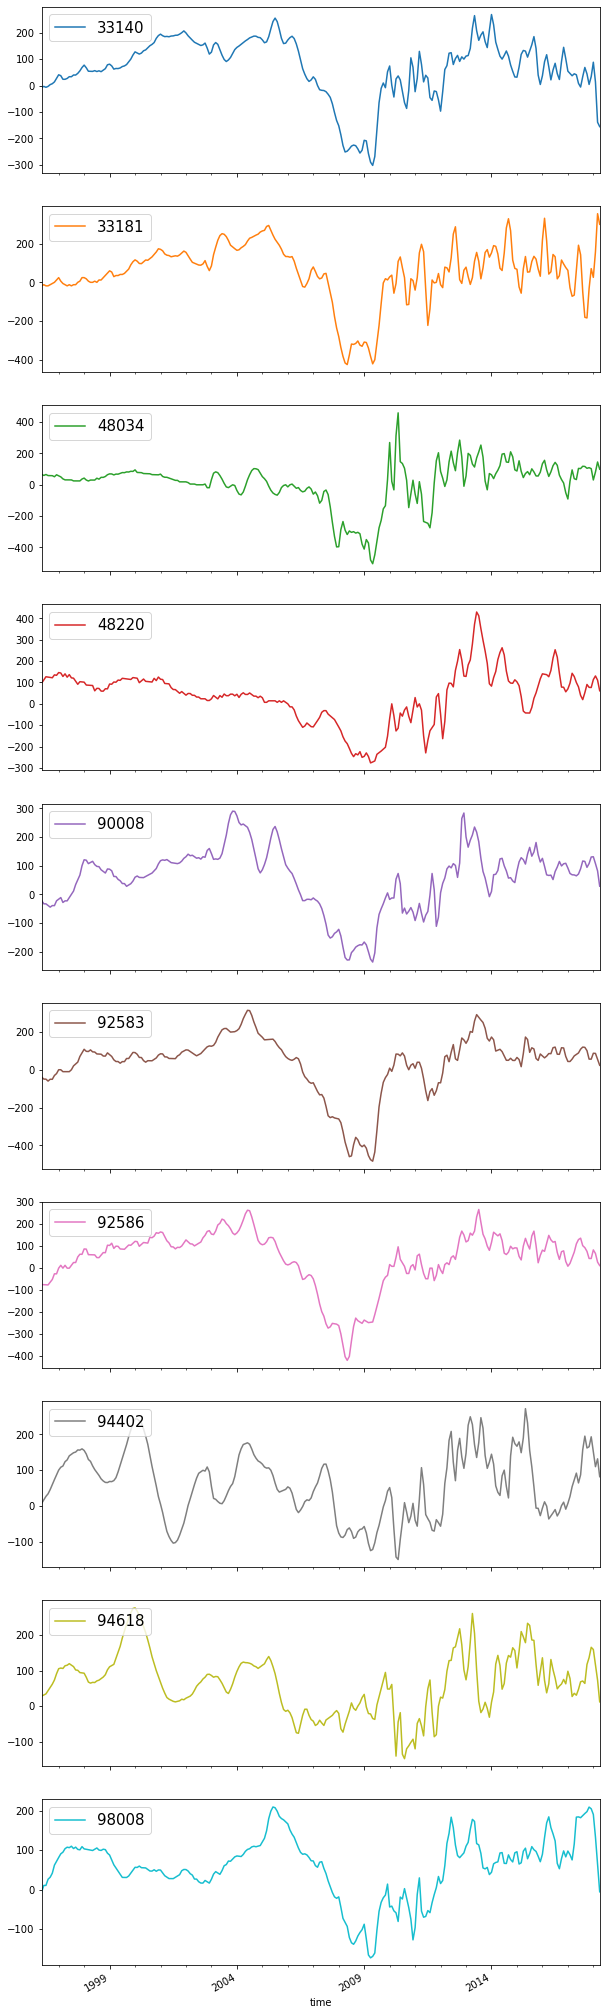

In [63]:
plot_moving_average(dense_top10)

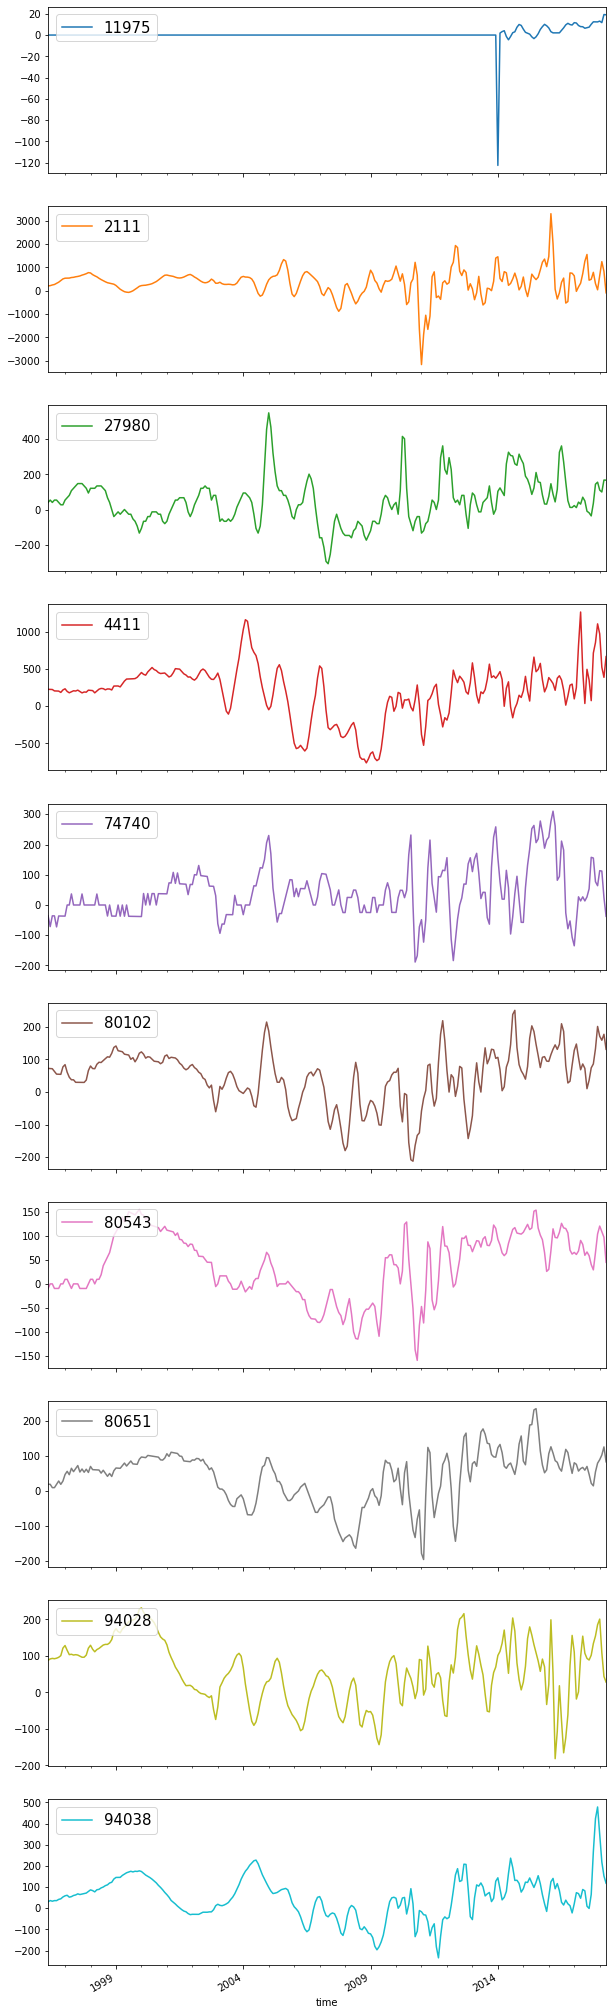

In [64]:
plot_moving_average(nd_top10)

It's tough to eyeball, and the plots do look a bit better, but there are still some hints of trend and seasonality in many of the zipcodes. Many of the not-dense zipcodes (ex. 00441), and medium-dense zipcodes (ex. 98008) still display an upward trend, especially after 2009 . Furthermore, seasonality is evident as some of the spikes in return on investment seem to occur at regular intervals. 

Before moving on, I will apply `seasonal_decompose` and log-transform the series to see if that has an effect on getting rid of some of the remaining trend and seasonality.  

## Building Initial Model 

We want to build a time series model to predict the future ROI for the 30 zipcodes across our three datasets. But first, we will select one specific zipcode to build our timeseries model on. Then, we'll implement a similar workflow on teh other zipcodes in our datasets to identify which zipcodes have the highest ROI. 

To accomplish this, I will take the zipcode with the highest ROI in the mid-size city dataset.

In [65]:
dense_top10.groupby(by=['zipcode']).mean()['avg_roi']

zipcode
33140    99.45
33181    99.12
48034    99.90
48220    98.66
90008    99.38
92583    99.30
92586    99.69
94402    98.98
94618    99.54
98008    99.89
Name: avg_roi, dtype: float64

The zipcode with the highest average ROI since 2009 is 33140, which is located in Miami Beach, Fl.

In [66]:
miami = dense_top10.loc[dense_top10['zipcode'] == '33140']

In [67]:
#Again, only want model to be based on data after June 2009 
miami = miami['2009-06-01':]

## Seasonal Decomposition to Further Improve Stationarity

In [68]:
#Create function to quickly transform to timeseries and log data
def drop_and_log (df): 
    df = df.drop(['zipcode','population','City','State','Metro','CountyName','SizeRank','avg_roi','value','difference'], axis=1)
    ts = np.log(df)
    ts[ts == -np.inf] = 1
    ts = ts.fillna(0)
    return ts

## Stationarity Test

In [69]:
miami_ts = drop_and_log(miami)

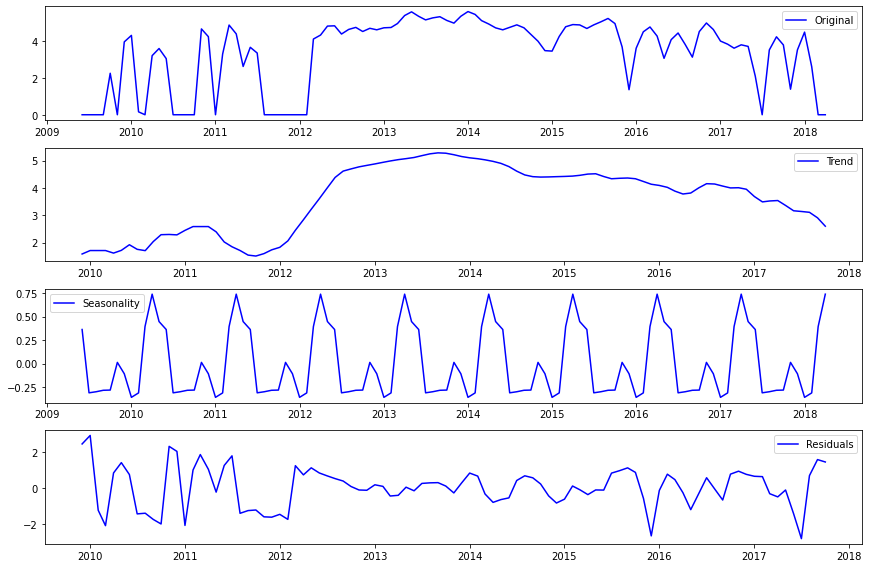

In [70]:
#Apply seasonal_decompose (log-transform series)
decomposition = seasonal_decompose(miami_ts)
#Gather the trend, seasonality,  and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
#Plot gathered statistics 
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(miami_ts, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

The `seasonal_decompose` function shows that the data have an slight downward trend, seasonal fluctuations, and fairly random residuals.

## Preprocessing 

#### Train-Test Split

In [71]:
# Find the index which allows us to split off 20% of the data
# Calculate the 80% mark by multiplying the row index of the shape attribute
# Use the built in round function to find the nearest integer 

end_of_train_index = round(miami_ts.shape[0] * .8)
end_of_train_index

86

In [72]:
# Define train and test sets according to the index found above 
# For our starting model on the Miami zipcode
miami_train = miami_ts.iloc[:end_of_train_index]
miami_test = miami_ts.iloc[end_of_train_index:]

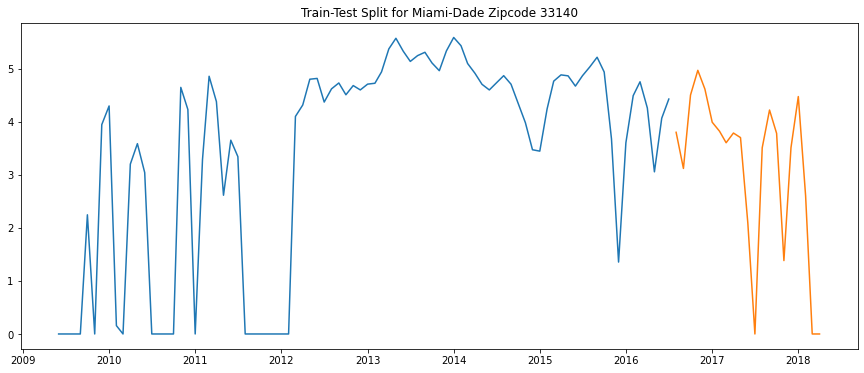

In [73]:
# Looking at big city dataset as an example
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(miami_train)
ax.plot(miami_test)
ax.set_title('Train-Test Split for Miami-Dade Zipcode 33140');

## Modeling
### Model 1: Random Walk
For the first model I'll try simply predicting the next data point with the point previous to it. Then, we can run an ARIMA model and a gridsearch to see if any of our more sophisticated models can outperform a random walk.

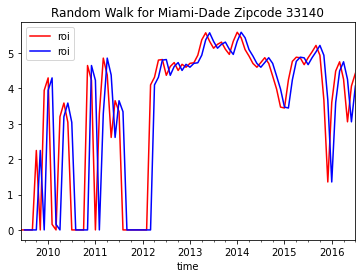

In [74]:
miami_random_walk = miami_train.shift(1)

fig, ax1 = plt.subplots()

miami_train[0:500].plot(ax=ax1, c='r', label='original')
miami_random_walk[0:500].plot(ax=ax1, c='b', label='shifted')
ax1.set_title('Random Walk for Miami-Dade Zipcode 33140')
ax1.legend();

In [75]:
# Calculate Root Mean Squared Error for above data 
miami_residuals = miami_random_walk - miami_train
miami_rw_rmse = mean_squared_error(miami_train[1:], miami_random_walk.dropna(),squared=False)
miami_rw_rmse

1.4035451516561488

I'll next see if a gridsearch of an ARIMA model can do better than the RMSE for my random walk. Since a random walk just takes a difference of 1, it is like using an ARIMA model with hyperparameters (0,1,0).

### Model 2: ARIMA
### Picking Hyperparameter Values
After some research, I decided to try a gridsearch of an ARIMA model rather than an auto-ARIMA, because I liked the idea of being able to hand-select the hyperparameters based on where I saw lags in my data.

Before writing the gridsearch, I want to investigate autocorrelations to determine lags. 

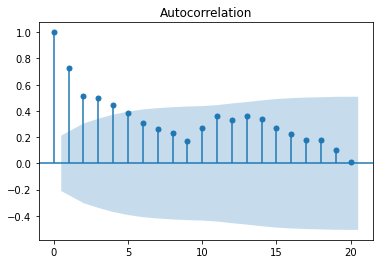

In [76]:
#Original Miami data
plot_acf(miami_train);

The above autocorrelation suggests that there is a correlation between lags up to about 5 weeks back. Does the first difference/random walk do any better?

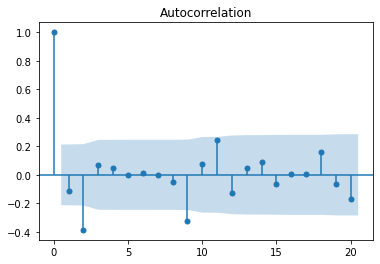

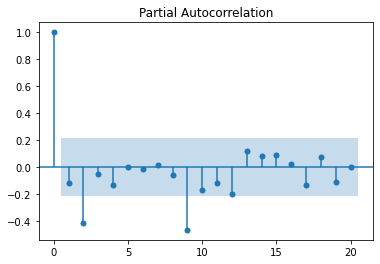

In [77]:
#(0,1,0) model results
plot_acf(miami_train.diff().dropna());
plot_pacf(miami_train.diff().dropna());

Both plots show significant lags at 3 and 10. Furthermore, the plot appears overdifferenced at 2 and 3. I decided to consider all parameters between 0 and 9 (for p and d) and 1 or 2 (for moving average/q) given the significant lags at these values.

### Selecting Some Parameters Manually

In [78]:
# Function to quickly play around with different parameters
# Prints root mean squared error of function 
def rmse_arima(ts, p, d, q): 
    model = ARIMA(ts, order =(p,d,q)).fit()
    preds = model.predict(typ='levels')
    rmse = np.sqrt(mean_squared_error(ts, preds))
    return rmse

def aic_arima(ts, p, d, q): 
    model = ARIMA(ts, order = (p,d,q)).fit()
    aic = model.aic
    return aic

In [79]:
rmse_arima(miami_train, 3, 1, 1)

1.2452847447108228

In [80]:
aic_arima(miami_train, 3, 1, 1)

289.59181113224264

In [81]:
rmse_arima(miami_train, 3, 1, 2)

1.2422514834850804

In [82]:
aic_arima(miami_train, 3, 1, 2)

291.08920628825416

In [83]:
rmse_arima(miami_train, 9, 1, 2)

1.136731413158278

In [84]:
rmse_arima(miami_train, 9, 2, 2)

1.2091323797103954

In [85]:
rmse_arima(miami_train, 9, 1, 4)

1.1130884237118075

In [86]:
aic_arima(miami_train, 9, 1, 2)

283.90108309659473

In [87]:
aic_arima(miami_train, 9, 1, 4)

283.12512775214805

In [88]:
rmse_arima(miami_train, 10, 1, 2)

1.1367327418181983

In [89]:
aic_arima(miami_train, 10, 1, 2)

285.9008913311237

The root mean squared error appears to minimize as the model approach 9 lags, but the AIC appears to increase after 9 lags. Further, a difference of 1 (rather than 2) appears to be optimal. For my gridsearch, I'll use a range of 0-9 lags, a difference of 1, and an MA value range of 0-4.

### Building ARIMA Model and Gridsearch

Now that I have an idea of the parameter ranges I would like to use, I can build a function that conducts gridsearch of the hyperparameter ranges that I specified above, in order to find the best-performing parameters. 

In [90]:
from pmdarima import auto_arima

In [91]:
auto_arima(miami_train, start_p=0, start_q=0, max_p=9, max_q=5, D=1, seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=302.733, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=303.591, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=300.185, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=300.850, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=287.523, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=289.471, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=289.484, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=286.455, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=298.485, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=288.455, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=288.455, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=292.205, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=290.037, Time

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

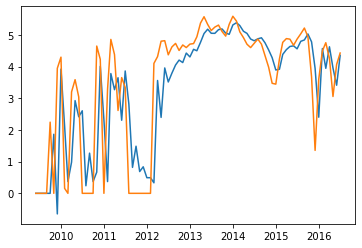

In [92]:
#Plotting training predictions
aa_model = ARIMA(miami_train,order=(0,1,2)).fit()
y_hat_train = aa_model.predict(typ='levels')

fig, ax=plt.subplots()
ax.plot(y_hat_train);
ax.plot(miami_train);

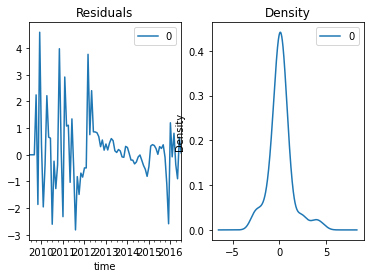

In [93]:
# Plot residual errors
residuals = pd.DataFrame(aa_model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [94]:
rmse_arima(miami_train, 0, 1, 2)

1.2513180562968946

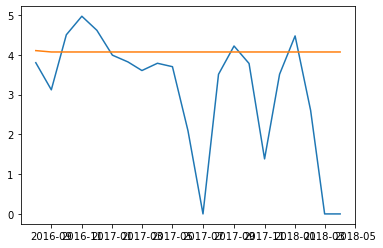

In [95]:
# Predicting on test data 
y_hat_test = aa_model.predict(start=miami_test.index[0], end=miami_test.index[-1], typ='levels')

fig, ax = plt.subplots()
ax.plot(miami_test);
ax.plot(y_hat_test);

In [96]:
np.sqrt(mean_squared_error(miami_test, y_hat_test))

1.7829836542446977

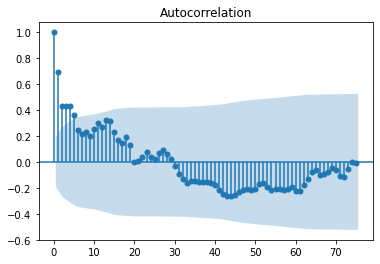

In [97]:
plot_acf(miami_ts, lags=75);

The ARIMA model did not perform so hot on the testing data, indicating that there is seasonality I'm not accounting for. I'll try an auto-ARIMA gridsearch for a SARIMAX model next, by adding the seasonal hyperparameters (P,D,and Q) into the highest-performing ARIMA identified by the gridsearch.  

### Model Refinement

In [98]:
# Running auto_arima
auto_arima(y=miami_train, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=302.733, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=304.329, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=302.156, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=300.850, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=302.757, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=302.797, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=304.756, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=303.591, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=300.185, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=302.157, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=287.523, Time=0.08 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=289.142, Time=0.15 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AI

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [99]:
sa_mod = SARIMAX(miami_train,
                  order=(0, 1, 2),
                  seasonal_order=(0, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

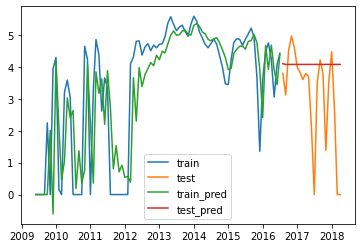

In [100]:
sa_y_hat_train = sa_mod.predict(typ='levels')
sa_y_hat_test = sa_mod.predict(start=miami_test.index[0], end=miami_test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(miami_train, label='train')
ax.plot(miami_test, label='test')
ax.plot(sa_y_hat_train, label='train_pred')
ax.plot(sa_y_hat_test, label='test_pred')

plt.legend();

In [101]:
np.sqrt(mean_squared_error(miami_test, sa_y_hat_test))

1.7869849176816373

The parameters selected by the auto-ARIMA did not decrease the root mean squared error. Since I know the real estate prices span a period of 9 months (from April-December), I changed the period from 12 to 9 to see if that helps the model improve. 

In [102]:
sa_mod2 = SARIMAX(miami_train,
                  order=(0, 1, 2),
                  seasonal_order=(0, 1, 0, 9),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

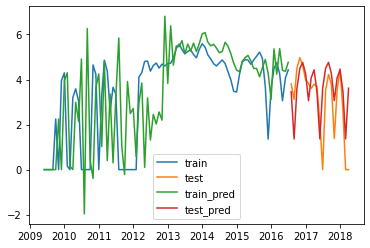

In [103]:
sa2_y_hat_train = sa_mod2.predict(typ='levels')
sa2_y_hat_test = sa_mod2.predict(start=miami_test.index[0], end=miami_test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(miami_train, label='train')
ax.plot(miami_test, label='test')
ax.plot(sa2_y_hat_train, label='train_pred')
ax.plot(sa2_y_hat_test, label='test_pred')

plt.legend();

In [104]:
np.sqrt(mean_squared_error(miami_test, sa2_y_hat_test))

1.3715689947816556

This 2nd version SARIMAX model looks a lot better and is also performing better on the test data than my random walk.

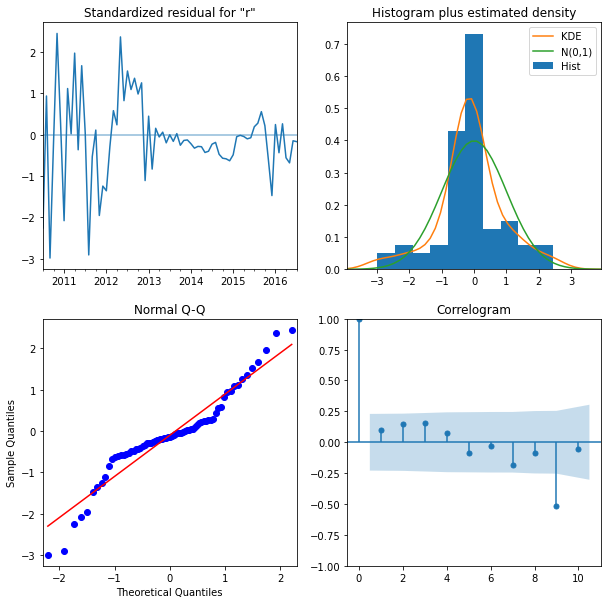

In [105]:
# Checking diagnostics to ensure that residuals are normally distributed and that 
# there is no unforeseen correlation
sa_mod2.plot_diagnostics(figsize=(10,10))
plt.show()

The residuals appear normally distributed, though if I have more time I'd work to mitigate the decreasing magnitude issue that is apparent from the standardized residual plot.  The residual also display low correlations with their lagged versions, aside from the correlation at 9 that I've already tried to account for. I'll use this version to predict on for the rest of my zipcodes.

### Forecasting on Final Model - Representative Zipcode

In [106]:
final_model = SARIMAX(miami_ts,
                  order=(0, 1, 2),
                  seasonal_order=(0, 1, 0, 9),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [107]:
#Predicting into the future one year out
forecast = final_model.forecast(steps = 12)

Text(0.5, 1.0, 'Miami-Dade Zipcode 33140 ROI Predictions (Logged) - One Year Out')

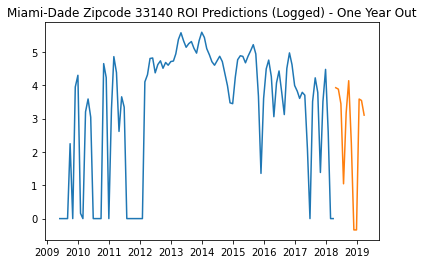

In [108]:
fig, ax = plt.subplots()
ax.plot(miami_ts)
ax.plot(forecast)
ax.set_title('Miami-Dade Zipcode 33140 ROI Predictions (Logged) - One Year Out')

## Forecasting
Now that I have a model optimized for our mid-city dataset, I will build a for-loop to iterate over each group of zip codes (starting with the mid-size dataset) and then predict the ROI that will be the highest in April 2020. 

In [109]:
dense_top10 = dense_top10.drop(labels = ['City', 'State', 'Metro', 'CountyName'], axis=1)

In [111]:
dense_top10 = dense_top10.astype('int')

In [114]:
zip_predictions = {}
#miami_budget_zips is a list of zipcodes in Miami-Dade County with average price under $300000
for zipcode in dense_zips: 
    #Selecting only the timestamps for our given zipcode
    zips = dense_top10.loc[dense_top10['zipcode'] == zipcode]
    series = zips['roi']
    #Only taking data from 2009 onwards to more accurately reflect current market conditions
    recent_series = series['2009-06-01':]
#     # Splitting the last 80% of our series as a test dataset.
#     end_of_train_index = round(recent_series.shape[0] * .8)
#     train_series = recent_series.iloc[:end_of_train_index]
#     test_series = recent_series.iloc[end_of_train_index:]
    # Plug the optimal parameter values for our Training data into a SARIMAX model that fits our entire series.
    sa_model = SARIMAX(train_series, order=(0, 1, 2),seasonal_order=(0, 1, 0, 9),enforce_stationarity=False,enforce_invertibility=False)
    # Fit the model and print results
    output = sa_model.fit()
    #Getting a forecast for the next 12 months after the last recorded date on our dataset.
    forecast = output.get_forecast(12)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    #Adding the Zipcode's ROI to the zip_predictions dictionary
    zip_predictions[zipcode] = ((prediction['prediction'][-1]) - (series['value'][-1]))/ (series['value'][-1])

IndexError: index 0 is out of bounds for axis 0 with size 0

1. Identify model parameters manually, get model that's doing better for a random walk
2. Run a gridsearch on a single zipcode to find model most optimized for single zipcode - can put that inside a for loop, where you're running through all zipcodes. 
3. Use model to find projected ROI for all zipcodes, through this find zipcode that has best projected ROI. 

## Conclusions and Next Steps

- Rental properties vs. residential 
- Update model with 2020 census results, then rerun. 